In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import gym
from itertools import count
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from collections import deque
import random
import matplotlib.pyplot as plt
from IPython import display

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:0') # so we can do .to(device)
    print("found GPU")
else:
    device = torch.device('cpu')
    print("no GPU")

no GPU


# Deep Q Networks (DQN)

DQN is an off-policy Q learning method. Unlike REINFORCE, DQN learns a Q networks (as opposed to policy) and can use trajectories that the agent has collected in the past to train the current Q network by storing them in a replay buffer. The learning objective in DQN is also different than in REINFORCE: DQN tries to minimize the **Temporal Difference (TD)** error (i.e., difference between prediction of Q values and the TD target). We are not going to talk about TD learning in detail here, but if you are especially interested to work with RL, I recommend you to look into TD learning and SARSA to have a better understanding about DQN. The TD target for DQN is defined as:

$$
Q_{target}(s,a) = r + \gamma \max_{a'}Q(s',a')
$$

The DQN algorithm is shown below:

<figure>
  <div style="text-align:center;">
  <img src="assets/05/dqn_algo.png", width = 600>
  <figcaption>Source: Mnih et al. (2013). Playing Atari with Deep Reinforcement Learning.</figcaption>
  </div>
</figure>

Note that depending on the use case, we may or may not use the feature network $\phi$ shown in the algorithm above. For this example, we know what the state is, so we do not need to differentiate between observations $x$ and states $s$.

In practice, we often use another network that is a lagged copy of the Q-network to generate the TD target in order to stabilize training. We call this a **target network**. If you are interested to know more about this, I encourage you to read the paper :)

Generally, with off-policy methods, one needs to be aware of memory usage since we are storing a lot of information in the replay buffer. This can be problematic especially when the state dimension is high (e.g., images).

Let's now take a look at the implementation.

In [14]:
env = gym.make('CartPole-v1', render_mode="rgb_array")

In [15]:
class ReplayBuffer():
    def __init__(self, buffer_size):
        # Use deque instead of list so we do not have to manually 
        # pop the buffer when it reaches max buffer size
        self.buffer = deque(maxlen = buffer_size) 
    
    def update(self, state, action, reward, next_state, done):
        """
        Function to push the data into buffer.
        Input:
            - state: state ndarray [state_dim (e.g., H x W x 3)]
            - action: int
            - reward: float
            - next_state: next_state ndarray [state_dim (e.g., H x W x 3)]
            - done: bool
        """
        self.buffer.append([state, action, reward, next_state, done])
    
    def sample(self, batch_size):
        """
        Function to sample a batch from replay buffer.
        Input:
            - batch_size: an int
        """
        samples = random.sample(self.buffer, batch_size)
        states = []
        actions = []
        rewards = []
        next_states = []
        dones = []
        for i in range(batch_size):
            state = samples[i][0]
            action = samples[i][1]
            reward = samples[i][2]
            next_state = samples[i][3]
            done = samples[i][4]
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
        return np.stack(states), np.stack(actions), np.stack(rewards), np.stack(next_states), np.stack(dones)

In [16]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, action_dim)

    def forward(self, inp):
        x = F.relu(self.dropout(self.fc1(inp)))
        out = self.fc2(x)
        return out

In [17]:
class DQNAgent(object):
    def __init__(self, state_dim, action_dim):
        super(DQNAgent, self).__init__()
        
        # DQN parameters
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.buffer_size = 1000
        self.epsilon_init = 1.0
        self.epsilon_end = 0.05
        self.epsilon_decay = 200
        self.gamma = 0.99
        self.log_interval = 250 # print progress per this many episodes
        self.target_update_freq = 10 # update target network per this many episodes
        
        # Models
        self.q_network = QNetwork(state_dim, action_dim).to(device)
        self.target_network = QNetwork(state_dim, action_dim).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict()) # copy of q_network
        self.replay_buffer = ReplayBuffer(self.buffer_size)
        
        # Optimizers
        self.q_network_optimizer = optim.Adam(self.q_network.parameters(), lr = 1e-2)
        self.q_network.train()
        self.target_network.eval() # We never train the network we use to generate the TD target!


    def get_action(self, state, epsilon):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device) # [1, dim_space]
        # Using epsilon greedy as our policy
        if np.random.random() > epsilon:
            with torch.no_grad():
                q_value = self.q_network(state) # [1, action_space]
                action  = q_value.max(1) # returns both the max values and max index
                action = action[1].data[0] # [1] indicates we want the max index
                action = action.item()
        else: # With probability epsilon, select random action
            action = random.randrange(self.action_dim)
        return action

    
    def update(self, batch_size):
        
        # Sample batch from replay buffer
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)
        
        # Convert ndarray to torch tensor
        states = torch.from_numpy(states).float().to(device)
        next_states = torch.from_numpy(next_states).float().to(device)
        rewards = torch.from_numpy(rewards).float().to(device)
        actions = torch.from_numpy(actions).long().to(device)
        dones = torch.from_numpy(dones).float().to(device)
        
        # Calculate TD error
        q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1) # [batch_size]
        next_q_values = self.target_network(next_states).max(1)[0].detach() # [0] indicates we want the max values (not the indices!), detach since this is the target # [batch_size]
        td_target = rewards + self.gamma * next_q_values * (1. - dones) 
        loss = F.mse_loss(q_values, td_target)
        
        # Update model
        self.q_network_optimizer.zero_grad()
        loss.backward()
        self.q_network_optimizer.step()

Let's start training the agent.

In [18]:
state_dim = 4
action_dim = 2
agent = DQNAgent(state_dim, action_dim)

In [19]:
batch_size = 32
running_reward = 10
target_update_freq = 10 # update target network every X episode
episode = 1 # indicate episode number

state, ep_reward = env.reset(), 0
state = state[0]
for i in range(1, 100000):
    
    # Update epsilon and pick action
    epsilon = agent.epsilon_end + (agent.epsilon_init - agent.epsilon_end) * np.exp(-1. * i / agent.epsilon_decay)
    action = agent.get_action(state, epsilon)

    # Take a step
    next_state, reward, terminated, truncated, _ = env.step(action)
    env.render()

    # Update replay buffer
    agent.replay_buffer.update(state, action, reward, next_state, terminated)

    # Once replay buffer size is larger than batch size, start training
    if len(agent.replay_buffer.buffer) > batch_size:
        agent.update(batch_size)

    # Update episode reward and check for end episode
    ep_reward += reward
    if terminated or truncated: # If episode is done: update running reward, reset env, reset episode reward
        running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
        episode += 1 # increment episode count (used for updating target network)
        state, ep_reward = env.reset(), 0
        state = state[0]
    else:
        state = next_state

    # Occasionally, update the target_network by copying the q_network
    if episode % agent.target_update_freq == 0:
        agent.target_network.load_state_dict(agent.q_network.state_dict())
        
    if i % agent.log_interval == 0:
        print('Episode %d \t Running Reward: %.2f' 
              % (i, running_reward))
    
    # Stopping criteria
    if running_reward > 100:
        print('Solved: Episode %d \t Running Reward: %.2f' 
              % (i, running_reward))
        break

Episode 250 	 Running Reward: 12.74
Episode 500 	 Running Reward: 13.28
Episode 750 	 Running Reward: 13.72
Episode 1000 	 Running Reward: 18.34
Episode 1250 	 Running Reward: 21.91
Episode 1500 	 Running Reward: 21.78
Episode 1750 	 Running Reward: 25.33
Episode 2000 	 Running Reward: 30.51
Episode 2250 	 Running Reward: 33.65
Episode 2500 	 Running Reward: 30.81
Episode 2750 	 Running Reward: 29.64
Episode 3000 	 Running Reward: 32.18
Episode 3250 	 Running Reward: 29.89
Episode 3500 	 Running Reward: 35.22
Episode 3750 	 Running Reward: 29.41
Episode 4000 	 Running Reward: 36.08
Episode 4250 	 Running Reward: 41.93
Episode 4500 	 Running Reward: 43.53
Episode 4750 	 Running Reward: 34.16
Episode 5000 	 Running Reward: 35.47
Episode 5250 	 Running Reward: 33.73
Episode 5500 	 Running Reward: 40.96
Episode 5750 	 Running Reward: 44.13
Episode 6000 	 Running Reward: 49.02
Episode 6250 	 Running Reward: 44.36
Episode 6500 	 Running Reward: 40.88
Episode 6750 	 Running Reward: 41.85
Epis

101.0


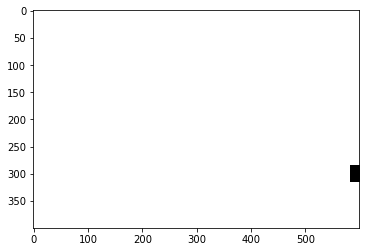

In [22]:
state = env.reset()
state = state[0]
terminated = False
truncated = False
total_reward = 0
while not (terminated or truncated):
    action = agent.get_action(state, 0.0)
    state, reward, terminated, truncated,  _ = env.step(int(action))
    total_reward += reward
    plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    if terminated or truncated:
        break
print(total_reward)

In [ ]:
env.close()